### How use this notebook on your computer
This Jupiter notebook is related to the Breon's thread :https://twitter.com/fmbreon/status/1338928777846530049
<br> and to the CIRED publication : https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3592447
<br>
<br>
Clone the CIRED GitHub  repository in your home directory : git clone https://github.com/BehrangShirizadeh/EOLES_elecRES.git
<br>Clone this notebook : git clone https://github.com/Bertin-fap/CIRED-ENS.git
<br> in home directory/CIRED-ENS lauch jupyter with the command: jupyter notebook
<br>
<br>
In addition you need to: 
- Download the RTE excel files from: https://www.rte-france.com/eco2mix/telecharger-les-indicateurs for each avalaible year yyyy unzip and rename yyyy.xlsx (for example 2013.xlsx). Drop the yyyy.xlsx files into a directory named RTE_DATA hosted in your home directory
- Download the csv file "Evolution du parc éolien" from https://www.statistiques.developpement-durable.gouv.fr/publicationweb/262 (this file is also available on github)
<br>
<br>
Configuation:
<br>
- python 3.6
- padas, numpy, matplotlib, loess

# Electric energy consumption analysis
Comparison between ADEME, RTE (2006) and Negawatt electric energy consumption profiles.

In [1]:
# read three electric energy consumption files issued from:
#      ADEME; 
#      Negawatt; 
#      year 2006 from RTE.
# the sampling time is 1h


from pathlib import Path
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline

directory_inputs = Path.home()/Path('EOLES_elecRES/inputs')

fe_2006 = pd.read_csv(directory_inputs / Path('demand2006.csv'),header = None)
deb = datetime.datetime(2006, 1, 1)
temps =[deb + datetime.timedelta(hours=i) for i in range(int(len(fe_2006)))]
fe_2006.drop([0], axis=1, inplace=True)
fe_2006.index = temps

fe_negawatt = pd.read_csv(directory_inputs / Path('demand2050_negawatt.csv'),header = None)
deb = datetime.datetime(2050, 1, 1)
temps =[deb + datetime.timedelta(hours=i) for i in range(int(len(fe_negawatt)))]
fe_negawatt.drop([0], axis=1, inplace=True)
fe_negawatt.index = temps

fe_ademe = pd.read_csv(directory_inputs / Path('demand2050_ademe.csv'),header = None)
fe_ademe.drop([0], axis=1, inplace=True)
deb = datetime.datetime(2050, 1, 1)
temps =[deb + datetime.timedelta(hours=i) for i in range(int(len(fe_ademe)))]
fe_ademe.index = temps


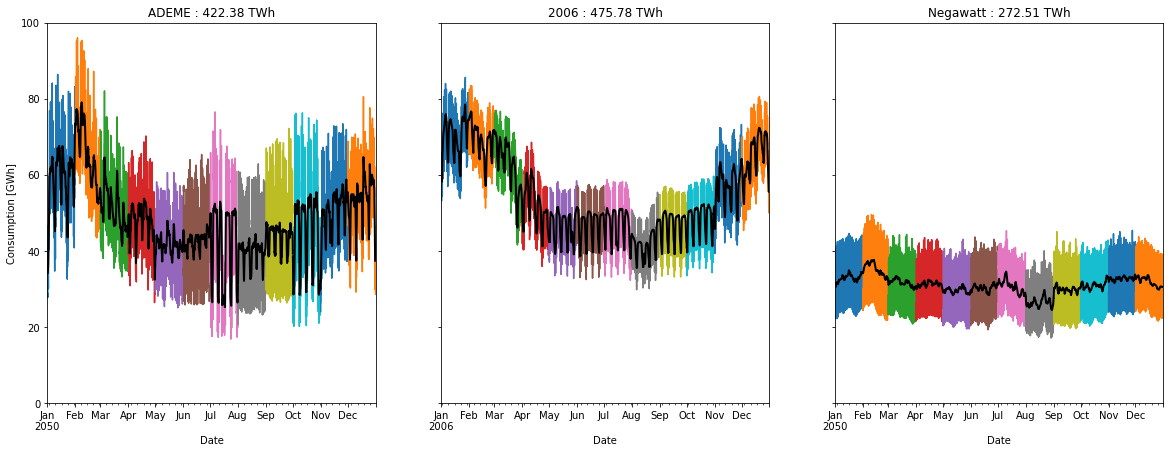

In [2]:
# plot three electricity consumptions (ADEME, Negawatt, year 2008 from RTE) versus time (sampling time=1h)
# plot the moving average (window length=24)

fig = plt.figure(figsize=(20,7))

ax1 = plt.subplot(1, 3, 1)
fe_ademe.resample('M').plot(label='raw consumption',ax=ax1)
plt.xlabel("Date")
plt.ylabel("Consumption [GWh]")
plt.title(f'ADEME : {round(fe_ademe[1].sum()/1000, 2)} TWh')
_=fe_ademe.rolling(window=24,center=True).mean().resample('M').plot(c='k',lw=2,label='24h averaging',ax=ax1)
plt.ylim(0,100)

ax2 = plt.subplot(1, 3, 2, sharey = ax1)
fe_2006.resample('M').plot(label='raw consumption',ax=ax2)
plt.xlabel("Date")
plt.title(f'2006 : {round(fe_2006[1].sum()/1000, 2)} TWh')
_=fe_2006.rolling(window=24,center=True).mean().resample('M').plot(c='k',lw=2,label='24h averaging',ax=ax2)
plt.ylim(0,100)

ax3 = plt.subplot(1, 3, 3, sharey = ax1)
fe_negawatt.resample('M').plot(label='raw consumption',ax=ax3)
plt.xlabel("Date")
plt.title(f'Negawatt : {round(fe_negawatt[1].sum()/1000, 2)} TWh')
_=fe_negawatt.rolling(window=24,center=True).mean().resample('M').plot(c='k',lw=2,label='24h averaging',ax=ax3)
_=plt.ylim(0,100)


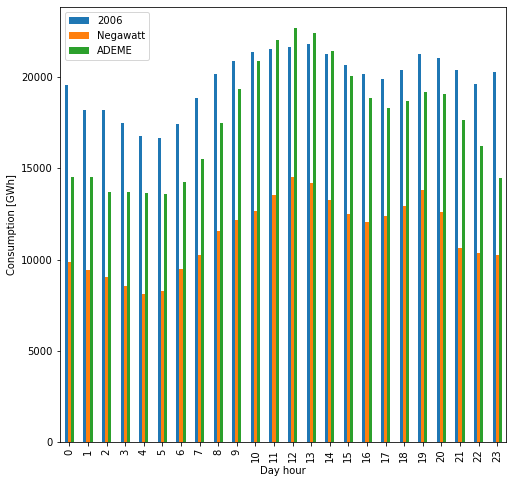

In [3]:
#Plot electricity consumption aggregated by day hour

dic = {}
dic['2006'] = fe_2006.groupby(fe_2006.index.hour).sum().values.flatten()
dic['Negawatt'] = fe_negawatt.groupby(fe_negawatt.index.hour).sum().values.flatten()
dic['ADEME'] = fe_ademe.groupby(fe_ademe.index.hour).sum().values.flatten()

new = pd.DataFrame.from_dict(dic)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
_=new.plot.bar(style='-o', lw=3, ax=ax)
_=plt.ylabel("Consumption [GWh]")
_=plt.xlabel("Day hour")

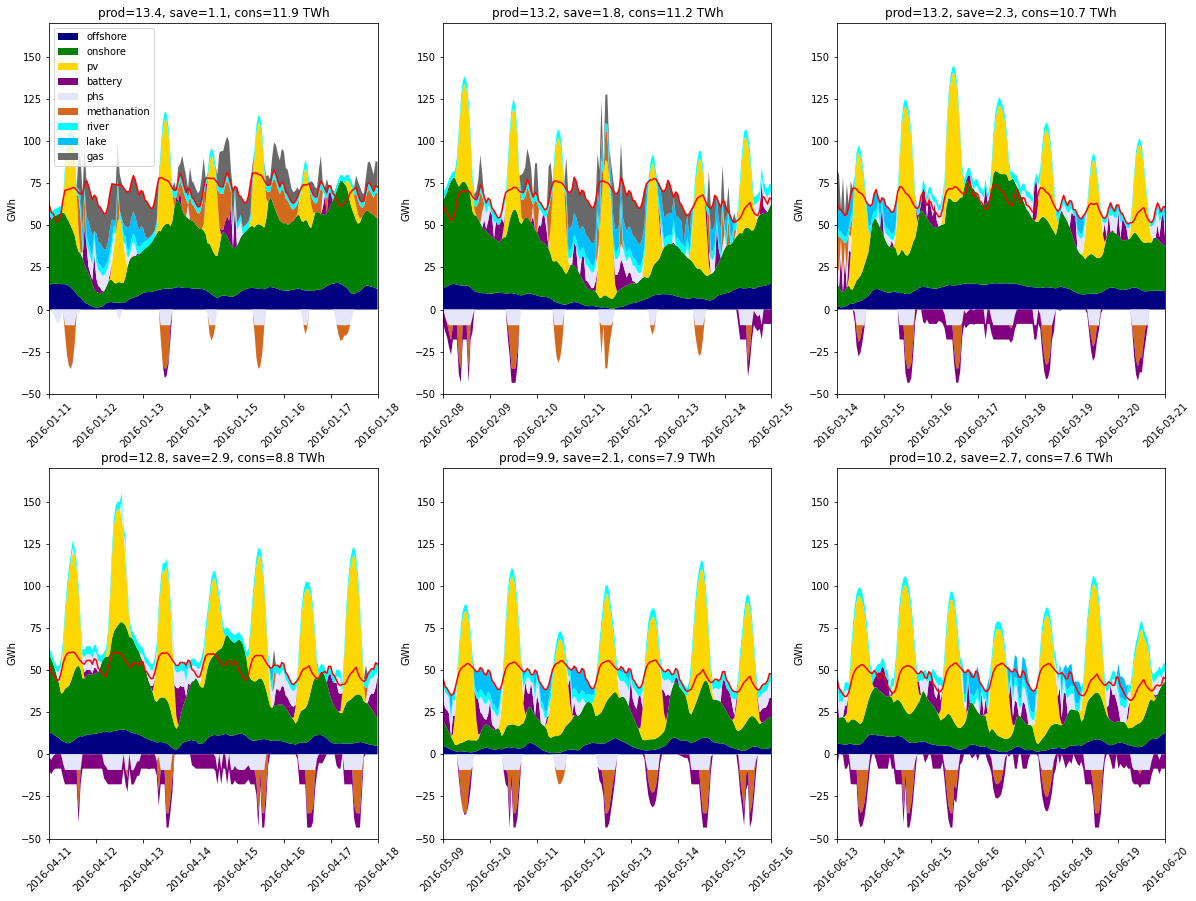

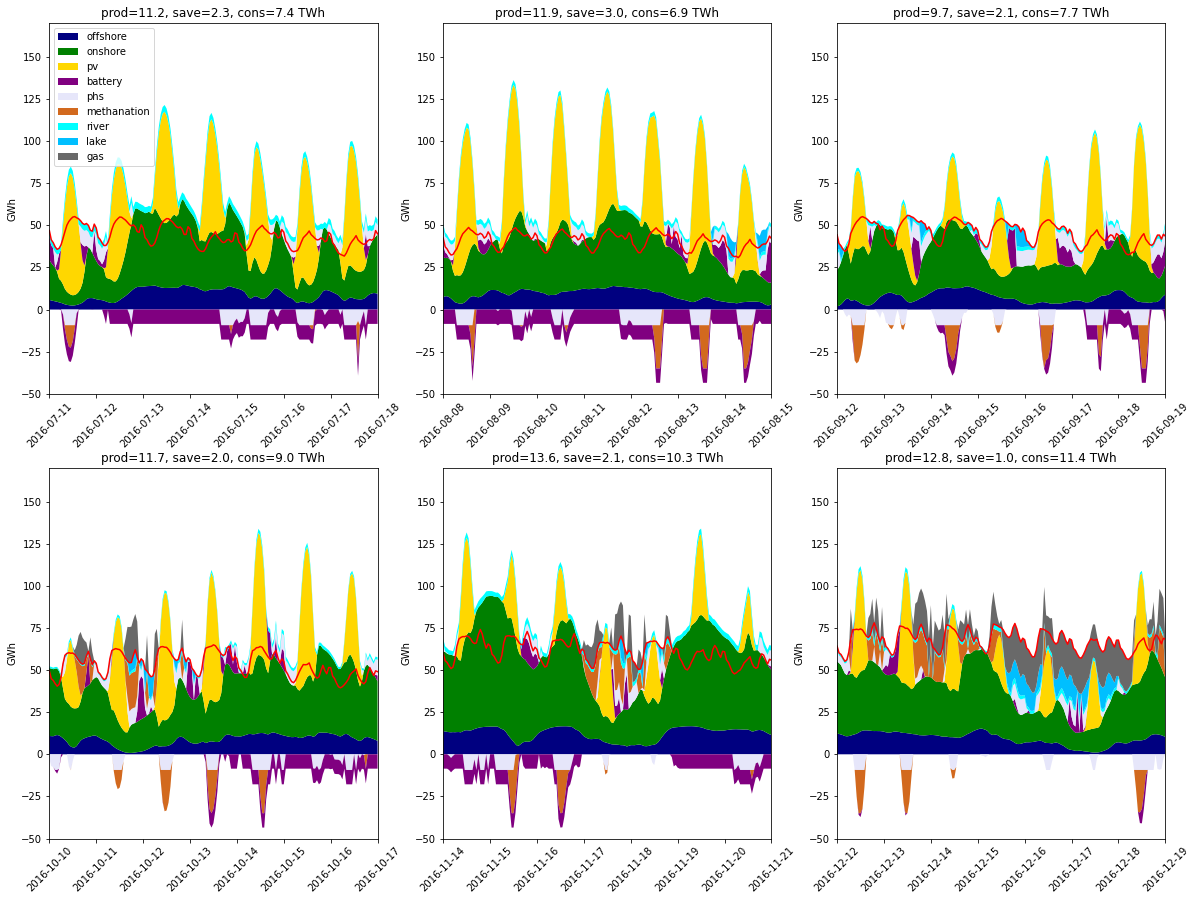

In [4]:
import pandas as pd
import datetime
from datetime import date 
import matplotlib.pyplot as plt
%matplotlib inline

def debut(i):
    ''' search the first day which is monday'''
    j = 0
    x = None
    while x != 'Monday':
        j += 1
        day_name = datetime.date(int(2016), int(i), int(j)) 
        x = day_name.strftime("%A")
    return j

directory_ouputs = Path.home()/Path('EOLES_elecRES/outputs/with 2016 demand')
deb = datetime.datetime(2016, 1, 1)

simul_2016 = pd.read_csv(directory_ouputs / Path('hourly profiles with demand of 2016.csv'))
temps =[deb + datetime.timedelta(hours=i) for i in range(int(len(simul_2016)))]
simul_2016.drop(['hour'], axis=1, inplace=True)
simul_2016.index = temps
demand = simul_2016["demand"]
CH4_SOC = simul_2016["CH4_SOC"]
simul_2016.drop(['demand',"elec_price", "gas_price",'Bat_SOC','PHS_SOC','CH4_SOC'], axis=1, inplace=True)

for split in range(2):
    fig = plt.figure(figsize=(20,15))

    for num_plot,i in enumerate(range(6*split,min(7*split+6,12))):
        d1 = debut(i+1)+7
        plt.subplot(2,3,num_plot+1)
        dep = f'2016-{i+1}-{d1} 00:00:00'
        fin = f'2016-{i+1}-{d1+7} 00:00:00'

        data = simul_2016[dep : fin]
        s1 = 0
        s2 = 0
        cons =0
        plt.stackplot(data.index, 
                      data['offshore'].values,
                      data['onshore'].values,
                      data['pv'].values,
                      data['battery'].values,
                      data['phs'].values,
                      data['methanation'].values,
                      data['river'].values,
                      data['lake'].values,
                      data['gas'].values,
                      colors=['navy',
                              'green',
                              'gold',
                              'purple',
                              'lavender',
                              'chocolate',
                              'aqua',
                              'deepskyblue',
                              'dimgray'],
                     labels =['offshore',
                             'onshore',
                             'pv',
                             'battery',
                             'phs',
                             'methanation',
                             'river',
                             'lake',
                             'gas'])


        plt.stackplot(data.index, 
                      data['Pump'].values,
                      data['ElecStr'].values,
                      data['CH4'].values,
                      colors=['lavender','chocolate','purple'])
        prod = round((sum(data['offshore'].values) +
              sum(data['onshore'].values) +
              sum(data['pv'].values)+
              sum(data['battery'].values)+
              sum(data['phs'].values)+
              sum(data['methanation'].values)+
              sum(data['river'].values)+
              sum(data['lake'].values)+
              sum(data['gas'].values))/1000,1)
        sav = round((sum(data['Pump'].values) +
              sum(data['ElecStr'].values) +
              sum(data['Pump'].values)+
              sum(data['CH4'].values))/1000,1)
        cons = round(sum(demand[dep : fin])/1000,1)
        plt.plot(data.index,demand[dep : fin].values,'r' )
        plt.xticks(rotation = 45)
        plt.xlim(min(data.index),max(data.index))
        plt.ylim(-50,170)
        plt.ylabel('GWh')
        plt.title(f'prod={prod}, save={-sav}, cons={cons} TWh')
        if num_plot == 0  : plt.legend(loc=2)

# Wind load factor analysis
comparaison between CIRED and RTE results

In [8]:
def read_rte(year):
    '''
    reading of  an excel RTE file downloaded from https://www.rte-france.com/eco2mix/telecharger-les-indicateurs
    Unzip the file and remame then yyyy.xlsx where yyyy stands for the 4 digits of the year.
    
    Arguments:
        year (int) : year of the RTE excel file to be read
    Returns:
        B (dataframe): datafame of the RTE file
    '''
    from pathlib import Path
    import pandas as pd
    import os

    directory_rte = Path.home()/Path('RTE_DATA')
    path = directory_rte / Path(str(year) + '.xlsx')

    A = pd.read_excel(path,
                      skipfooter=1,                                  # skip the last line which is a comment
                      parse_dates=[['Date', 'Heures']],              # concanenate columns Date and Heures as TimeStamp
                      usecols='c:E,H:Q')                             # select columns
    A.drop([i for i in list(A.index)[1::2]],inplace=True)            # drop irrelevent rows
    index_ = [x for i,x in enumerate(A['Date_Heures']) if i%2 == 0 ] # resample every hour and convert in energy
    A.drop(columns=['Date_Heures'], inplace=True)
    B = A.groupby(A.index//4).mean()
    B['Date_Heures'] = index_
    B.set_index('Date_Heures',inplace=True)
    return B

def read_parc_eolien():
    
    '''
    reading of  an excel RTE file downloaded from:
    https://www.statistiques.developpement-durable.gouv.fr/publicationweb/262
    
    Arguments:
        
    Returns:
        Pow_eol (dict): {year:nominal_pwer(GW)}
    '''
    from pathlib import Path
    import pandas as pd
    import os

    directory_eol = Path.home()/Path('CIRED-ENS')
    path = directory_eol / Path('Évolution du parc éolien.csv')

    Pow_eol = pd.read_csv(path, sep=';', parse_dates=['Date'],usecols=['Date','Terrestre'])
    Pow_eol.set_index('Date',inplace=True) 
    Pow_eol = Pow_eol.dropna()
    Pow_eol = Pow_eol.resample("Y").mean()
    Pow_eol.index = Pow_eol.index.year
    Pow_eol = Pow_eol['Terrestre'] .to_dict()
    
    return Pow_eol

def read_LF_CIRED(year,technic):
    '''
    reading of  an excel CIRED file
    
    Arguments:
    year (int): year must be in [2006,2012,...,2017]
        
    Returns:
        Pow_eol (dict): {year:nominal_pwer(GW)}
    '''
    import pandas as pd
    
    fe = pd.read_csv(directory_inputs/Path('vre_profiles'+str(year)+'.csv'),header = None)
    deb = datetime.datetime(year, 1, 1)
    fe.rename(columns={0:"Technic",1:"Hour",2:str(year)}, inplace=True )
    fe.query('Technic==@technic', inplace=True)
    fe.index = [deb + datetime.timedelta(hours=i) for i in range(len(fe))]
    fe.drop(['Technic','Hour'], axis=1, inplace=True)
    
    return fe

Text(0, 0.5, 'CIRED - RTE Wind Load Factor')

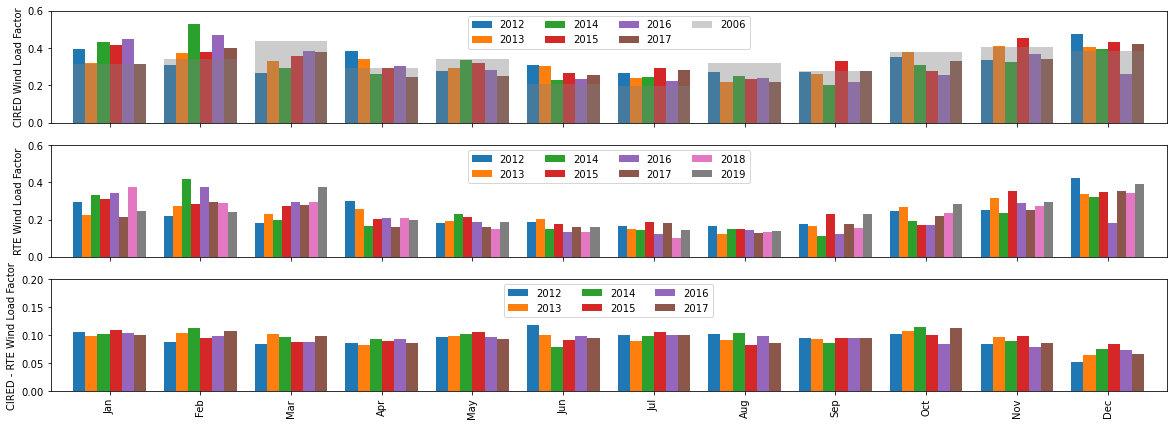

In [25]:
from pathlib import Path
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline


    
directory_inputs = Path.home()/Path('EOLES_elecRES/inputs')

##############################
#   builds CIRED dataframe   #
##############################

fe = read_LF_CIRED(2006,"onshore")
LF_onshore = fe.resample('M').mean()
LF_onshore.index = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec']
dic_CIRED_g = {}
for year in range(2012,2018):
    LF_CIRED = read_LF_CIRED(year,"onshore")
    dic_CIRED_g[year] = LF_CIRED.values
    LF_onshore[str(year)] = LF_CIRED.resample('M').mean().values

##############################
#   builds RTE dataframe     #
##############################

P_eol = read_parc_eolien()
dic_rte = {}
dic_RTE_g = {}
for year in range(2012,2020):
    B = read_rte(year)
    dic_RTE_g[year] = (B['Eolien']/P_eol[year]).values
    dic_rte[str(year)] = (B['Eolien']/P_eol[year]) .resample('M').mean().values[0:12] # take 12 months

LF_RTE = pd.DataFrame.from_dict(dic_rte)
LF_RTE.index = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec']

##############################
#         plot results       #
##############################

fig = plt.figure(figsize=(20,7))

ax1 = plt.subplot(3,1,1)
LF_onshore[['2012','2013','2014','2015','2016','2017']].plot(kind='bar', width=0.8, ax=ax1)
LF_onshore[['2006']].plot(kind='bar', ax=ax1, alpha=0.4,color='grey', width=0.8)
_=plt.ylim(0,0.6)
ax1.legend(loc=9,ncol=4)
plt.ylabel("CIRED Wind Load Factor")

ax2 = plt.subplot(3,1,2,sharex = ax1)
LF_RTE.plot(kind='bar', width=0.8, ax=ax2)
ax2.legend(loc=9,ncol=4)
_=plt.ylim(0,0.6)
plt.ylabel("RTE Wind Load Factor")

ax3 = plt.subplot(3,1,3,sharex = ax1)
LF_diff = LF_onshore[["2012","2013","2014","2015","2016","2017"]]-LF_RTE[["2012","2013","2014","2015","2016","2017"]]

LF_diff.plot(kind='bar', width=0.8, ax=ax3)
ax3.legend(loc=9,ncol=3)
_=plt.ylim(0,0.2)
plt.ylabel("CIRED - RTE Wind Load Factor")

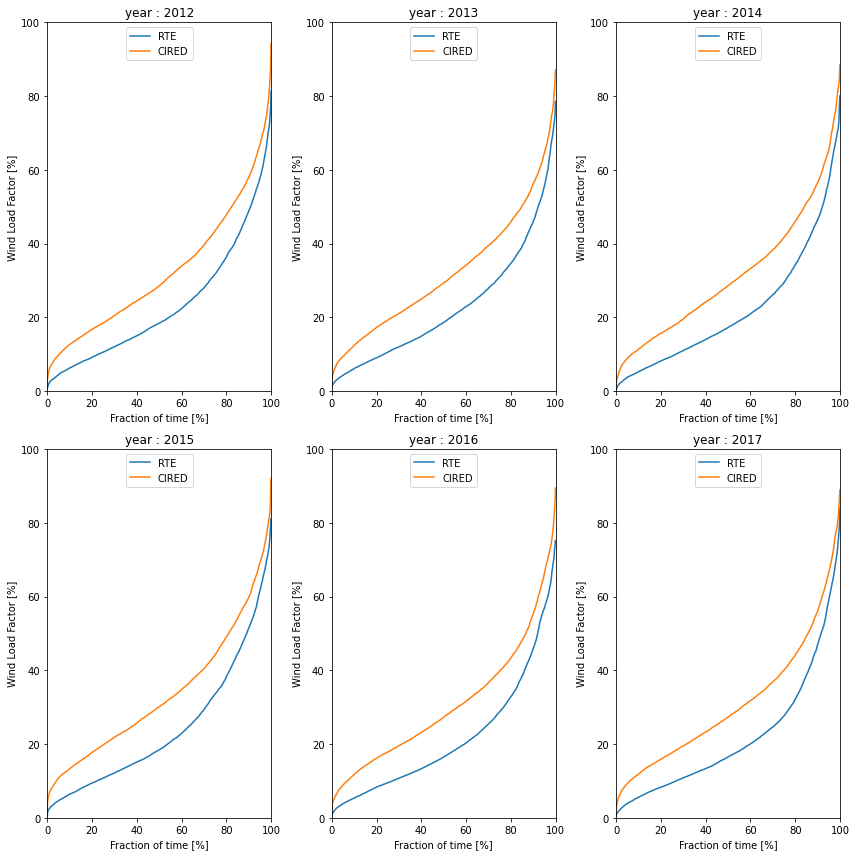

In [29]:
import numpy as np 
fig = plt.figure(figsize=(12,12))
for idx,year in enumerate(range(2012,2018)):
    plt.subplot(2,3,idx+1)
    plt.plot(np.arange(0,100,0.1),np.percentile(np.array(dic_RTE_g[year])*100,np.arange(0,100,0.1)),label="RTE")
    plt.plot(np.arange(0,100,0.1),np.percentile(np.array(dic_CIRED_g[year])*100,np.arange(0,100,0.1)),label="CIRED")
    plt.legend(loc=9)
    plt.title(f'year : {year}')
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.xlabel("Fraction of time [%]")
    plt.ylabel("Wind Load Factor [%]")
fig.tight_layout()

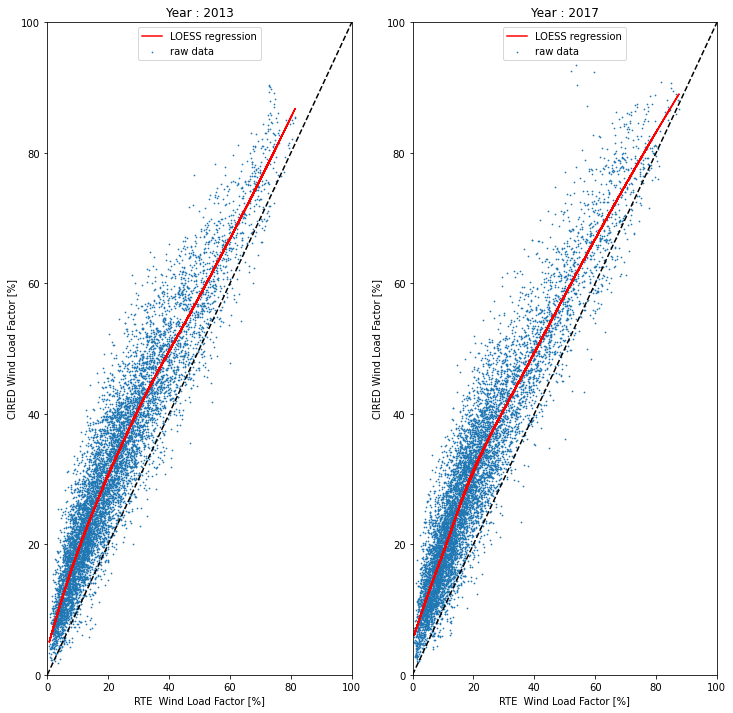

In [11]:
from loess.loess_1d import loess_1d
fig = plt.figure(figsize=(12,12))
for idx, year in enumerate([2013,2017]):
    plt.subplot(1,2,idx+1)
    plt.scatter(np.array(dic_RTE_g[year])*100,np.array(dic_CIRED_g[year])*100,s=0.5,label='raw data')
    xout, yout, weigts = loess_1d(np.array(dic_RTE_g[year])*100,(np.array(dic_CIRED_g[year]).flatten())*100, frac=0.6, degree=2)
    plt.plot(xout, yout,'r',label='LOESS regression')
    plt.plot([0,100],[0,100],'--k')
    plt.xlim(0,100)
    plt.ylim(0,100)
    plt.xlabel("RTE  Wind Load Factor [%]")
    plt.ylabel("CIRED Wind Load Factor [%]")
    _=plt.legend(loc=9)
    plt.title(f'Year : {year}')


# Wind load factor analysis
comparaison between CIRED and RTE results

use the wiki site : https://fr.wikipedia.org/wiki/%C3%89nergie_solaire_en_France for the evolution of the french solar capacity per year

In [18]:
def read_parc_solaire():
    
    '''
    WEB scrapping ot the wiki page : https://fr.wikipedia.org/wiki/%C3%89nergie_solaire_en_France and extract
    the table : Puissance photovoltaïque par région (MW)
    Valid 30/12/2020
    
    Arguments:
        
    Returns:
        Pow_sol (dict): {year:nominal_pwer(MW)}
    '''
    import pandas as pd

    url = 'https://fr.wikipedia.org/wiki/%C3%89nergie_solaire_en_France'
    import pandas as pd

    tables = pd.read_html(url, header=0)

    headings = set(['Région', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016',
                '2017', '2018']) # must be updated with wiki upgrade
    
    for table in tables: # find the table named "Puissance photovoltaïque par région (MW)"
        if set(table.columns.values) == headings:
            break 

    Pow_sol = table.query('Région=="Total France"').to_dict('records')[0]
    del Pow_sol['Région']
    Pow_sol = {int(key) : int(str(value).replace('\xa0','')) for key, value in Pow_sol.items()} # data cleaning
    Pow_sol[2012] = 3727
    Pow_sol[2013] = 4366
    Pow_sol[2019] = 9900 # https://www.statistiques.developpement-durable.gouv.fr/tableau-de-bord-solaire-photovoltaique-quatrieme-trimestre-2019
    return Pow_sol

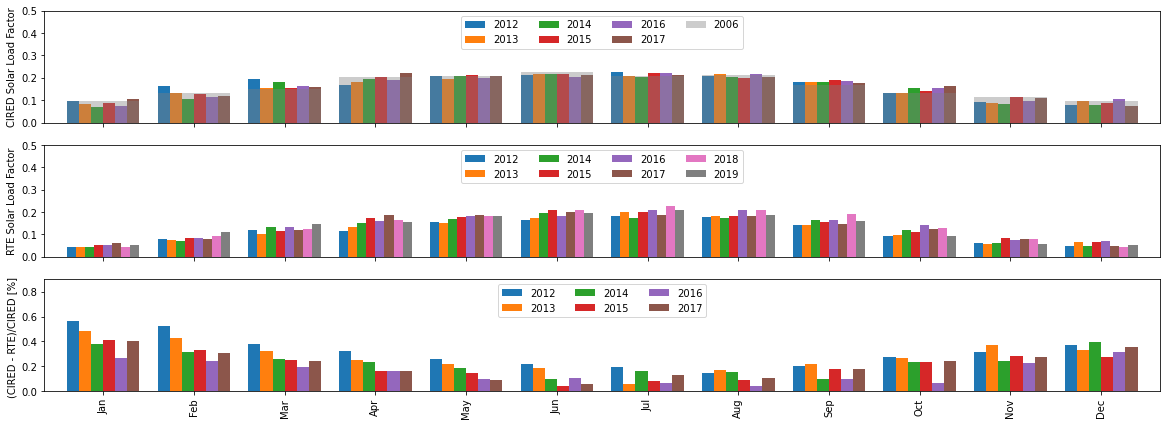

In [22]:
from pathlib import Path
import pandas as pd
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
    
directory_inputs = Path.home()/Path('EOLES_elecRES/inputs')

##############################
#   builds CIRED dataframe   #
##############################

fe = read_LF_CIRED(2006,'pv')
LF_pv = fe.resample('M').mean()
LF_pv.index = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec']
dic_CIRED_g = {}
for year in range(2012,2018):
    LF_CIRED = read_LF_CIRED(year,'pv')
    dic_CIRED_g[year] = LF_CIRED.values
    
    try: # loosy correction of a bug : pv CIRED has an additional hour value for year 2015
        LF_pv[str(year)] = LF_CIRED.resample('M').mean().values
    except:
        LF_pv[str(year)] = LF_CIRED[0:-1] .resample('M').mean().values

##############################
#   builds RTE dataframe     #
##############################

P_pv = read_parc_solaire()
dic_RTE = {}
dic_RTE_g = {}
for year in range(2012,2020):
    B = read_rte(year)
    dic_RTE_g[year] = (B['Solaire']/P_pv[year]).values
    dic_RTE[str(year)] = (B['Solaire']/P_pv[year]) .resample('M').mean().values[0:12] # take 12 months

LF_RTE = pd.DataFrame.from_dict(dic_RTE)
LF_RTE.index = [ 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov','Dec']

##############################
#         plot results       #
##############################

fig = plt.figure(figsize=(20,7))

ax1 = plt.subplot(3,1,1)
LF_pv[['2012','2013','2014','2015','2016','2017']].plot(kind='bar', width=0.8, ax=ax1)
LF_pv[['2006']].plot(kind='bar', ax=ax1, alpha=0.4,color='grey', width=0.8)
_=plt.ylim(0,0.5)
ax1.legend(loc=9,ncol=4)
plt.ylabel("CIRED Solar Load Factor")

ax2 = plt.subplot(3,1,2,sharex = ax1)
LF_RTE.plot(kind='bar', width=0.8, ax=ax2)
ax2.legend(loc=9,ncol=4)
_=plt.ylim(0,0.5)
plt.ylabel("RTE Solar Load Factor")

ax3 = plt.subplot(3,1,3,sharex = ax1)
LF_diff = (LF_pv[["2012","2013","2014","2015","2016","2017"]]-LF_RTE[["2012","2013","2014","2015","2016","2017"]]) \
           /LF_pv[["2012","2013","2014","2015","2016","2017"]]

LF_diff.plot(kind='bar', width=0.8, ax=ax3)
ax3.legend(loc=9,ncol=3)
_=plt.ylim(0,0.9)
_=plt.ylabel("(CIRED - RTE)/CIRED [%] ")